In [1]:
import pandas as pd
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import io
from PIL import Image
from warnings import filterwarnings
import ipywidgets as widgets
from IPython.display import display,clear_output

for dAdi, _, dosyalar in os.walk('/kaggle/input'):
    for dosya in dosyalar:
        print(os.path.join(dAdi, dosya))

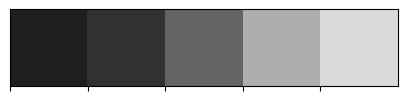

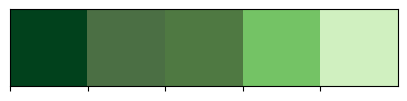

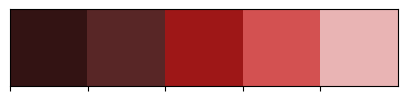

In [2]:
darkPalet = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
redPalet = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
yesilPalet = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(darkPalet)
sns.palplot(yesilPalet)
sns.palplot(redPalet)

In [3]:
siniflar = ['glioma_tumoru','tumorsuz','meninjiyom_tumoru','hipofiz_tumoru']

In [4]:
X_train = []
y_train = []
gorselBoyutu = 150

for k in siniflar:
    klasorYolu = os.path.join('D:/Bitirme_Projesi_201307038/','Training',k)
    for j in tqdm(os.listdir(klasorYolu)):
        image = cv2.imread(os.path.join(klasorYolu,j))
        image = cv2.resize(image,(gorselBoyutu, gorselBoyutu))
        X_train.append(image)
        y_train.append(k)
        
for k in siniflar:
    klasorYolu = os.path.join('D:/Bitirme_Projesi_201307038/','Testing',k)
    for j in tqdm(os.listdir(klasorYolu)):
        image = cv2.imread(os.path.join(klasorYolu,j))
        image = cv2.resize(image,(gorselBoyutu,gorselBoyutu))
        X_train.append(image)
        y_train.append(k)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 80.19it/s]


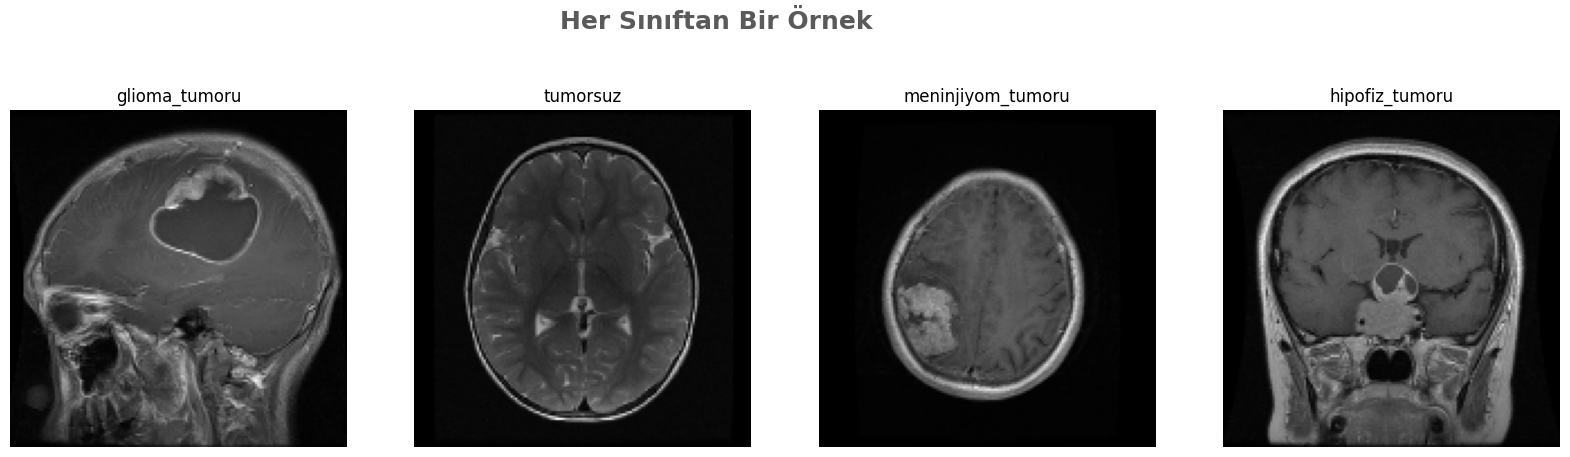

In [5]:
p=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Her Sınıftan Bir Örnek', size=18, fontweight='bold', color=darkPalet[1], y=0.62, x=0.4, alpha=0.8)
for i in siniflar:
    j=0
    while True :
        if y_train[j]==i:
            ax[p].imshow(X_train[j+13])
            ax[p].set_title(y_train[j])
            ax[p].axis('off')
            p+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(3264, 150, 150, 3)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(siniflar.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(siniflar.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
efficientNet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(gorselBoyutu, gorselBoyutu, 3))

In [10]:
model = efficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientNet.input, outputs = model)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])

In [12]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [13]:
# TensorBoard callback'ini tanımlama
tensorBoard = TensorBoard(log_dir='logs')
# ModelCheckpoint callback'ini tanımlama
checkPoint = ModelCheckpoint("efficientNet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
# ReduceLROnPlateau callback'ini tanımlama
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)


In [14]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32, callbacks=[tensorBoard,checkPoint,reduceLR])

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7233 - loss: 0.6881
Epoch 1: val_accuracy improved from -inf to 0.82993, saving model to efficientNet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.7244 - loss: 0.6856 - val_accuracy: 0.8299 - val_loss: 0.5944 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9339 - loss: 0.1896
Epoch 2: val_accuracy improved from 0.82993 to 0.90136, saving model to efficientNet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9340 - loss: 0.1896 - val_accuracy: 0.9014 - val_loss: 0.2831 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9559 - loss: 0.1249
Epoch 3: val_accuracy did not improve from 0.90136
83/83 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.9559 - loss: 0.1248 - val_accuracy: 0.7449 - val_loss: 1.1525 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9738 - loss: 0.0890
Epoch 4: val_accur

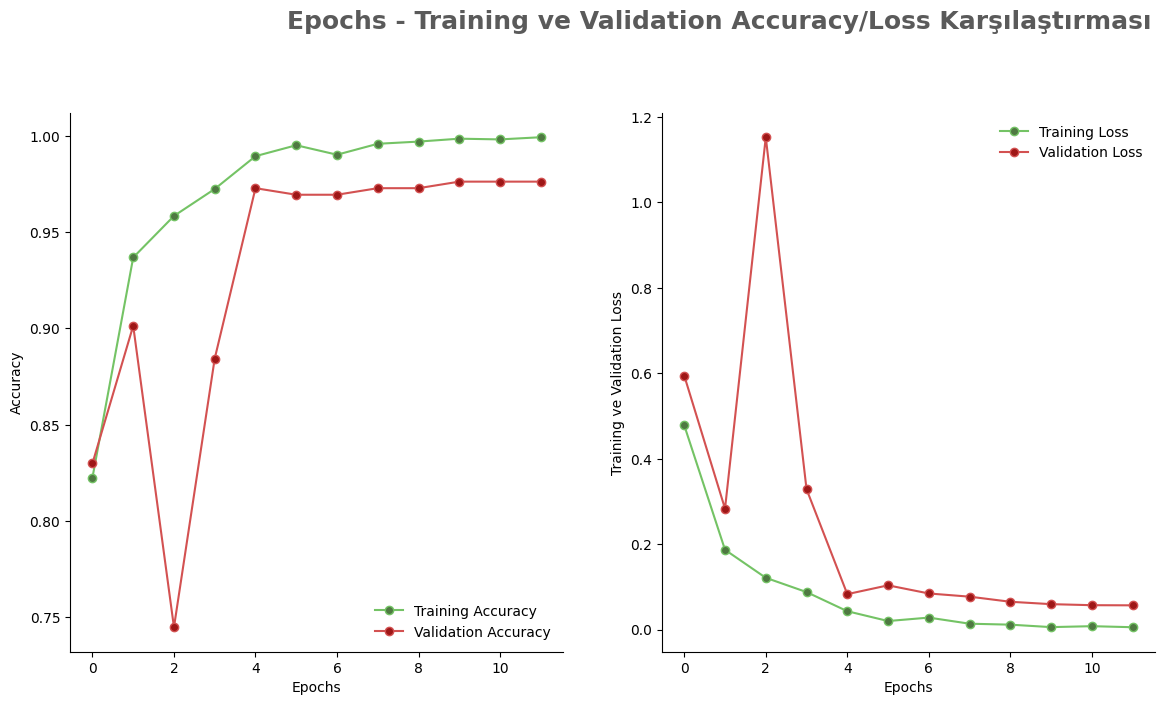

In [15]:
filterwarnings('ignore')   # uyarıları ignore et

epochs = [j for j in range(12)]
figur, axis = plt.subplots(1, 2, figsize=(14,7))

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
train_loss = history.history['loss']

figur.text(s='Epochs - Training ve Validation Accuracy/Loss Karşılaştırması', size=18, fontweight='bold', color=darkPalet[1], y=1, x=0.28, alpha=0.8)

sns.despine()
axis[0].plot(epochs, train_acc, marker='o',markerfacecolor=yesilPalet[2],color=yesilPalet[3], label = 'Training Accuracy')
axis[0].plot(epochs, val_acc, marker='o',markerfacecolor=redPalet[2],color=redPalet[3], label = 'Validation Accuracy')
axis[0].legend(frameon=False)
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Accuracy')

sns.despine()
axis[1].plot(epochs, train_loss, marker='o',markerfacecolor=yesilPalet[2],color=yesilPalet[3], label ='Training Loss')
axis[1].plot(epochs, val_loss, marker='o',markerfacecolor=redPalet[2],color=redPalet[3], label = 'Validation Loss')
axis[1].legend(frameon=False)
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Training ve Validation Loss')

figur.show()

In [16]:
tahmin = model.predict(X_test)

tahmin = np.argmax(tahmin, axis=1)

y_yeniTest = np.argmax(y_test, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 631ms/step


In [25]:
print(classification_report(y_yeniTest, tahmin))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        94
           1       0.95      1.00      0.97        54
           2       0.99      0.96      0.97        94
           3       0.99      1.00      0.99        85

    accuracy                           0.98       327
   macro avg       0.97      0.98      0.98       327
weighted avg       0.98      0.98      0.98       327



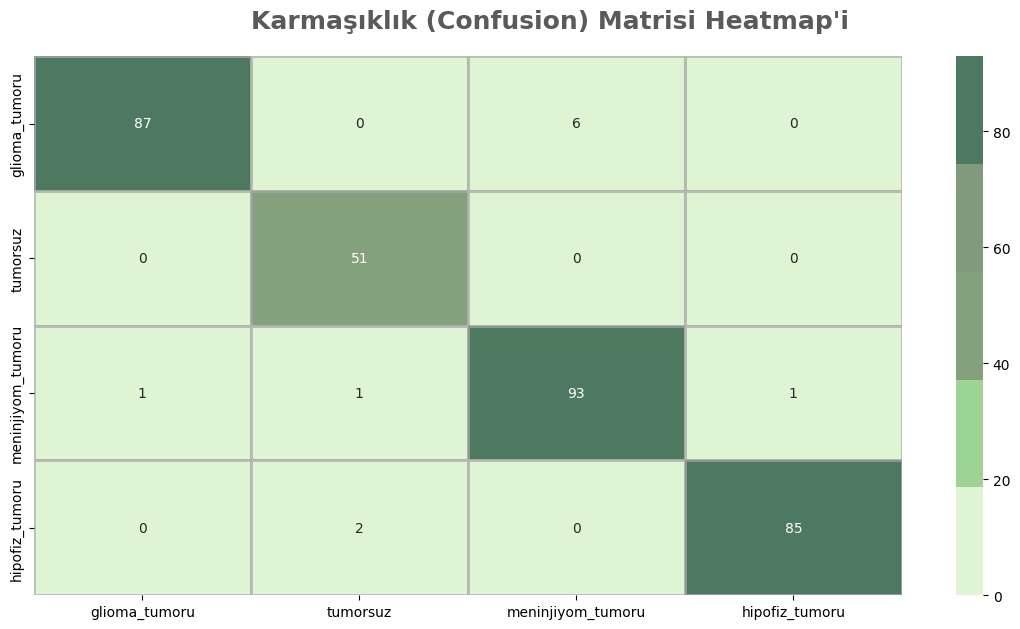

In [17]:
figur2,axis2=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_yeniTest,tahmin),ax=axis2,xticklabels=siniflar,yticklabels=siniflar,annot=True, cmap=yesilPalet[::-1],alpha=0.7,linewidths=2,linecolor=darkPalet[3])
figur2.text(s='Karmaşıklık (Confusion) Matrisi Heatmap\'i',size=18,fontweight='bold',color=darkPalet[1],y=0.92,x=0.28,alpha=0.8)
plt.show()

In [18]:
def tahmin_et(image):
    try:
        opencvImage = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        image = cv2.resize(opencvImage, (150, 150))
        image = image.reshape(1, 150, 150, 3)
        p = model.predict(image)
        p = np.argmax(p, axis=1)[0]

        if p == 0:
            p = 'Glioma Tümörü'
        elif p == 1:
            return 'Model, tümör olmadığını öngörüyor.'
        elif p == 2:
            p = 'Meninjiyom Tümörü'
        else:
            p = 'Hipofiz Tümörü'

        if p != 1:
            return f'Model bunun bir {p} olduğunu öngörüyor.'
    except Exception as e:
        return f'HATA!! : {str(e)}'

In [19]:
with open('D:/Bitirme_Projesi_201307038/Testing/tumorsuz/image(4).jpg', 'rb') as file:
    img = Image.open(file)
    result = tahmin_et(img)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Model, tümör olmadığını öngörüyor.


In [20]:
with open('D:\Bitirme_Projesi_201307038\Testing\hipofiz_tumoru\image(8).jpg', 'rb') as file:
    img = Image.open(file)
    result = tahmin_et(img)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Model bunun bir Hipofiz Tümörü olduğunu öngörüyor.


In [21]:
with open('D:\Bitirme_Projesi_201307038\Testing\meninjiyom_tumoru\image(17).jpg', 'rb') as file:
    img = Image.open(file)
    result = tahmin_et(img)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Model bunun bir Meninjiyom Tümörü olduğunu öngörüyor.


In [22]:
with open('D:\Bitirme_Projesi_201307038\Testing\glioma_tumoru\image(19).jpg', 'rb') as file:
    img = Image.open(file)
    result = tahmin_et(img)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Model bunun bir Glioma Tümörü olduğunu öngörüyor.


In [23]:
with open('D:/Bitirme_Projesi_201307038/tahminetg.jpg', 'rb') as file:
    img = Image.open(file)
    result = tahmin_et(img)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Model bunun bir Glioma Tümörü olduğunu öngörüyor.


In [24]:
with open('D:/Bitirme_Projesi_201307038/tahminetm.jpg', 'rb') as file:
    img = Image.open(file)
    result = tahmin_et(img)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Model bunun bir Meninjiyom Tümörü olduğunu öngörüyor.


In [25]:
with open('D:/Bitirme_Projesi_201307038/tahminetp.jpg', 'rb') as file:
    img = Image.open(file)
    result = tahmin_et(img)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Model bunun bir Hipofiz Tümörü olduğunu öngörüyor.


In [26]:
with open('D:/Bitirme_Projesi_201307038/tahminetty.jpg', 'rb') as file:
    img = Image.open(file)
    result = tahmin_et(img)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Model, tümör olmadığını öngörüyor.
